# <center><h3>Creación de un *dataset* de películas cinematográficas</h3><img src="img\logo.png" style="width:180px" alt="detalle película"/></center>

## Introducción

Este documento explica el proceso para crear un *script* en lenguaje **Python** que, mediante *[web scraping](https://es.wikipedia.org/wiki/Web_scraping)*, permita generar un conjunto de datos con fichas técnicas y valoraciones de diferentes películas cinematográficas. Estos datos podrán ser utilizados posteriormente para analizar algoritmos de clasificación o diseñar un sistema de recomendación de películas sencillo. Estos últimos están hoy en día presentes en todas las plataformas de contenidos audiovisuales bajo demanda, siendo capaces de presentar a sus usuarios sugerencias sobre películas o series acordes a sus gustos y preferencias.

En este caso práctico los datos serán extraídos del sitio web de críticas cinematográficas [Rotten Tomatoes](https://www.rottentomatoes.com). Uno de los agregadores de reseñas de películas y programas de televisión más veteranos y populares de Internet, cuyo sistema de puntuación o "*[tomatometer](https://www.rottentomatoes.com/about)*" se basa en las opiniones de cientos de críticos de cine y televisión.

La siguiente imagen muestra la [página](https://www.rottentomatoes.com/top) de este sitio que se tomará como punto de partida para extraer los datos, en ella aparece señalado el listado al que se accederá para consultar cuales son las películas mejor valoradas en cada categoría:

<img src="img\rotten_topmovies.png" style="width:550px" alt="top películas por género"/>

Los enlaces del listado anterior dan a su vez acceso a los denominados "*Top 100*" de cada categoría. En la siguiente imagen se puede ver, por ejemplo, el perteneciente a las películas clasificadas como "*Action and Adventure*":

<img src="img\rotten_topaction.png" style="width:550px" alt="top películas de acción"/>

Seleccionando uno de las entradas del listado anterior se accede a la ficha de la película elegida, en la que se muestran, entre otros datos, su valoración y datos técnicos, tal y como se puede ver en esta imagen:

<img src="img\rotten_movie_detail.png" style="width:450px" alt="detalle película"/>

A continuación se describen los pasos necesarios para crear el programa Python que generará el *dataset* de las películas a partir de estas páginas web.

### 1. Importar las librerías necesarias

El primer paso en la elaboración de este *script* será importar las librerías que utilizaremos para generar el *dataset*:

In [1]:
import whois
import builtwith
import requests
import time
import re
from bs4 import BeautifulSoup
from selenium.webdriver import Chrome
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import pandas as pd
import matplotlib.pyplot as plt

### 2. Información del sitio web

A continuación intentaremos averiguar quién es el propietario del sitio web, la tecnología que utiliza y las posibles restricciones a la hora de aplicar técnicas de *web scraping* a su contenido de acceso público.

#### Propietario

Dado que se trata de un dominio ".com" y este código TLD (*Top Level Domain*) no está sujeto a tantas restricciones de privacidad como otros dominios, vamos a utilizar una de las utilidades de *[WHOIS](https://es.wikipedia.org/wiki/WHOIS)* que existen en Python.

In [2]:
url =  "http://www.rottentomatoes.com"
print(whois.whois(url))

{
  "domain_name": [
    "ROTTENTOMATOES.COM",
    "rottentomatoes.com"
  ],
  "registrar": "MarkMonitor, Inc.",
  "whois_server": "whois.markmonitor.com",
  "referral_url": null,
  "updated_date": [
    "2021-04-12 10:14:43",
    "2021-04-12 03:14:43"
  ],
  "creation_date": [
    "1999-05-14 08:36:32",
    "1999-05-14 01:36:32"
  ],
  "expiration_date": [
    "2023-05-14 08:37:07",
    "2023-05-14 00:00:00"
  ],
  "name_servers": [
    "UDNS1.ULTRADNS.NET",
    "UDNS2.ULTRADNS.NET",
    "udns2.ultradns.net",
    "udns1.ultradns.net"
  ],
  "status": [
    "clientDeleteProhibited https://icann.org/epp#clientDeleteProhibited",
    "clientTransferProhibited https://icann.org/epp#clientTransferProhibited",
    "clientUpdateProhibited https://icann.org/epp#clientUpdateProhibited",
    "clientUpdateProhibited (https://www.icann.org/epp#clientUpdateProhibited)",
    "clientTransferProhibited (https://www.icann.org/epp#clientTransferProhibited)",
    "clientDeleteProhibited (https://www.ican

Como se puede observar, el registro del dominio parece estar a nombre de la empresa [Mark Monitor](https://www.markmonitor.com), aunque si atendemos a la información publicada en [Wikipedia](https://es.wikipedia.org/wiki/Rotten_Tomatoes), no sería el propietario sino de la empresa que gestiona el dominio.

#### Tecnología

Ahora vamos a intentar averiguar la tecnología utilizada en este sitio web:

In [3]:
print(builtwith.builtwith(url))

{'cdn': ['Akamai']}


Desafortunadamente no podemos obtener esta información ya que la función de la librería sólo nos devuelve el nombre de la [empresa](https://www.akamai.com/es/es/) propietaria de la red de distribución de contenidos ([CDN](https://es.wikipedia.org/wiki/Red_de_distribuci%C3%B3n_de_contenidos)) con la que parece trabajar este sitio.

#### Contenido del fichero *robots.txt*

A continuación vamos a comprobar si existen limitaciones a la hora de hacer *web scraping* en este sitio  web. Para ello visualizaremos el contenido de su fichero *robots.txt*:

In [4]:
url_robots = "https://www.rottentomatoes.com/robots.txt"
robots = requests.get(url_robots)
print(robots.text)

User-agent: *
Disallow: /search
Sitemap: https://www.rottentomatoes.com/sitemap.xml



Como se puede ver, en el fichero apenas se establacen limitaciones para realizar inspecciones automatizadas de su contenido público, apareciendo como única restricción aquellas páginas que pertenecen al directorio "*/search*". 

### 3. Obtener los enlaces a las páginas de las películas

En este tercer paso vamos a obtener los enlaces a las fichas de las películas que aparecían en los listados de mejores valoradas de cada categoría. Para ello utilzaremos las librerías [Selenium WebDriver](https://www.selenium.dev/) y [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/).

* La primera nos permitirá ejecutar un navegador web al que le enviaremos comandos para visitar secuencialmente cada una de las páginas de los listados "*Top 100*" que se encuentran en https://www.rottentomatoes.com/top. 

* Mediante Beautiful Soup analizaremos los documentos HTML de cada uno de esos listados y extraeremos de ellos los enlaces a las fichas de las películas. 

La siguiente imagen muestra un ejemplo de algunas de las etiquetas HTML que se analizaran para extraer los enlaces a las páginas de las películas:

<img src="img\html_parser.png" style="width:420px" alt="detalle película"/>


In [5]:
driver = Chrome()
driver.implicitly_wait(5)
driver.get("https://www.rottentomatoes.com/top")

listaPeliculas = []
totalPeliculas = 0

# Esperamos 10 segundos
time.sleep(10)

# Localizamos el bloque que contiene los enlaces a las mejores películas de cada género
bloqueMejoresPeliculas = driver.find_elements(By.XPATH, '//a[contains(@href, "%s")]' % "top/bestofrt/top_100_")

# Extraemos los enlaces de las páginas top 100
enlacesTop100 = [enlace.get_attribute('href') for enlace in bloqueMejoresPeliculas]
# Extraemos las categorías de cada top 100 
categoriasTop100 = [ enlace.find_element_by_xpath(".//div").text.replace("Top 100","").replace("Movies","").strip() 
                     for enlace in bloqueMejoresPeliculas]

enlacesCategoriasTop100 = list(zip(categoriasTop100,enlacesTop100))

# Accedemos a cada una de las páginas para recuperar los enlaces a las películas recomendadas
for paginaTop in enlacesCategoriasTop100:    
    
    # Esperamos 3 segundos
    time.sleep(3)
    
    # Accedemos a la página del enlace
    driver.get(paginaTop[1])
    
    print ("Analizando: " + paginaTop[1])
    
    # Parseamos la página
    paginaTopGenero = driver.page_source    
    parserPaginaTopGenero = BeautifulSoup(paginaTopGenero, "html.parser")
    
    # Localizamos la tabla que contiene los enlaces a las reseñas de cada película
    cabeceraTablaTop100 = parserPaginaTopGenero.find(lambda tag:tag.name=="th" and "Rank" in tag.text)
    tablaTop100 = cabeceraTablaTop100.find_parents("table")[0]
    
    listaEnlacesPeliculas = []
    
    # Cargamos los enlaces de las reseñas de las películas
    for filaTop in tablaTop100.find_all("tr")[1:]:                 # evitamos la cabecera de la tabla        
        celdasTop = filaTop.find_all("td")
        listaEnlacesPeliculas.append(celdasTop[2].find("a")["href"])          
    
    listaPeliculas.append([paginaTop[0],listaEnlacesPeliculas])    
    totalPeliculas = totalPeliculas + len(listaEnlacesPeliculas)
    
driver.close()


Analizando: https://www.rottentomatoes.com/top/bestofrt/top_100_action__adventure_movies/
Analizando: https://www.rottentomatoes.com/top/bestofrt/top_100_animation_movies/
Analizando: https://www.rottentomatoes.com/top/bestofrt/top_100_art_house__international_movies/
Analizando: https://www.rottentomatoes.com/top/bestofrt/top_100_classics_movies/
Analizando: https://www.rottentomatoes.com/top/bestofrt/top_100_comedy_movies/
Analizando: https://www.rottentomatoes.com/top/bestofrt/top_100_documentary_movies/
Analizando: https://www.rottentomatoes.com/top/bestofrt/top_100_drama_movies/
Analizando: https://www.rottentomatoes.com/top/bestofrt/top_100_horror_movies/
Analizando: https://www.rottentomatoes.com/top/bestofrt/top_100_kids__family_movies/
Analizando: https://www.rottentomatoes.com/top/bestofrt/top_100_musical__performing_arts_movies/
Analizando: https://www.rottentomatoes.com/top/bestofrt/top_100_mystery__suspense_movies/
Analizando: https://www.rottentomatoes.com/top/bestofrt/to

El código anterior ha almacenado los enlaces a las páginas de cada película en una lista, junto a la categoría a la que pertenecen. A continuación vamos a visualizar una muestra del contenido de dicha lista:

In [6]:
# Mostramos los enlaces de las películas del primer Top 100
print(listaPeliculas[:1])

[['Action & Adventure', ['/m/black_panther_2018', '/m/avengers_endgame', '/m/mission_impossible_fallout', '/m/mad_max_fury_road', '/m/spider_man_into_the_spider_verse', '/m/wonder_woman_2017', '/m/dunkirk_2017', '/m/coco_2017', '/m/thor_ragnarok_2017', '/m/logan_2017', '/m/star_wars_the_last_jedi', '/m/star_wars_episode_vii_the_force_awakens', '/m/1000355-adventures_of_robin_hood', '/m/1011615-king_kong', '/m/spider_man_far_from_home', '/m/incredibles_2', '/m/zootopia', '/m/war_for_the_planet_of_the_apes', '/m/spider_man_homecoming', '/m/baby_driver', '/m/seven_samurai_1956', '/m/1013775-metropolis', '/m/jaws', '/m/up', '/m/shazam', '/m/the_dark_knight', '/m/treasure_of_the_sierra_madre', '/m/blade_runner_2049', '/m/1000121-39_steps', '/m/captain_america_civil_war', '/m/the_jungle_book_2016', '/m/harry_potter_and_the_deathly_hallows_part_2_2011', '/m/skyfall', '/m/lawrence_of_arabia', '/m/mission_impossible_rogue_nation', '/m/apocalypse_now', '/m/the_hurt_locker', '/m/the_lego_movie', 

Ahora visualizamos el total de enlaces a películas que se han almacenado:

In [7]:
# Mostramos el total de enlaces a películas obtenidos
print (totalPeliculas)

1610


### 4. Extraer y almacenar los datos de cada película

Una vez obtenida la lista de enlaces, vamos a recuperar y analizar cada una de las páginas para extraer el contenido con el que generaremos el *dataset*. Los datos que se recogerán son los siguientes: 
 * Título
 * Año
 * Sinopsis
 * Categoría
 * Valoración de la crítica profesional (puntuación "*tomatometer*") 
 * Opinión consensuada de la crítica profesional
 * Total de críticas profesionales recibidas
 * Valoración de los usuarios
 * Total de valoraciones de usuarios recibidas 
 * Ficha técnica: clasificación por edades, género, lenguaje, director, productor, guionista, fecha de estreno en cines, fecha de estreno en plataformas de *streaming*, ingresos generados, duración, sonido, relación de aspecto, colección de películas asociada y los nombres de los actores, director, productores y guionistas.
 * Enlace a la página de Rotten Tomatoes de la que se ha extraído la información
 
El siguiente código realizará este proceso analizando y extrayendo secuencialmente el contenido de la página de cada película de la lista de enlaces obtenida anteriormente, almacenando la información recuperada en una estructura *[dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)* de la librería [Pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), que será la que finalmente contenga el *dataset*:
 

In [8]:
# Declaramos la variable que almacenará el dataset
ds = None
ds = pd.DataFrame()

# Variable para registrar el total de filas leídas
numFila = 0

for item in listaPeliculas:
    
    categoria = item[0]
    peliculas = item[1]
    
    for pelicula in peliculas:
        
        # Esperamos 3 segundos
        # time.sleep(3)

        urlFichaPelicula = url + pelicula

        # Establecemos la cabecera de la petición request como navegador Chrome
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

        # Obtenemos la página
        paginaFichaPelicula = requests.get(urlFichaPelicula,headers=headers)
        
        # Si no podemos acceder a la página terminamos el proceso
        if paginaFichaPelicula.status_code != 200:
            print("Se ha producido un error: " + str(paginaFichaPelicula.status_code))
            break

        # Parseamos la página
        parserFichaPelicula = BeautifulSoup(paginaFichaPelicula.content, "html.parser")   

        # Guardamos el título
        tituloAnio = parserFichaPelicula.find("title").text.replace("- Rotten Tomatoes","") if parserFichaPelicula.find("title") else ""
        titulo = re.sub("\s\(\d{4}\)", "", tituloAnio).strip()
        ds.at[numFila, "title"] = titulo if titulo != "" else None
        
        # Guardamos el año
        anio = re.findall(r"\(\d{4}\)", tituloAnio)[0].replace("(","").replace(")","")
        ds.at[numFila, "year"] = anio
        
        # Guardamos la sinopsis
        sinopsis = parserFichaPelicula.find(id="movieSynopsis")
        ds.at[numFila, "synopsis"] = sinopsis.text.strip() if sinopsis else None 

        # Guardamos la valoración de la crítica
        valoracionCritica = parserFichaPelicula.find("score-board", {"class": "scoreboard"})["tomatometerscore"]     
        ds.at[numFila, "critic_score"] = valoracionCritica if valoracionCritica else None

        # Guardamos la valoración de los usuarios
        valoracionComunidad = parserFichaPelicula.find("score-board", {"class": "scoreboard"})["audiencescore"]    
        ds.at[numFila, "people_score"] = valoracionComunidad if valoracionComunidad else None

        # Guardamos el consenso de la crítica
        criticaGeneral = parserFichaPelicula.find("span", {"data-qa":"critics-consensus"})    
        ds.at[numFila,"consensus"] = criticaGeneral.text.strip() if criticaGeneral else None

        # Guardamos el total de críticas
        totalCriticas = parserFichaPelicula.find("a", {"data-qa":"tomatometer-review-count"})    
        ds.at[numFila,"total_reviews"] = totalCriticas.text.replace("Reviews","").strip() if totalCriticas else None
        
        # Guardamos el total de valoraciones
        totalValoraciones = parserFichaPelicula.find("a", {"data-qa":"audience-rating-count"})    
        ds.at[numFila,"total_ratings"] = totalValoraciones.text.replace("Ratings","").strip() if totalValoraciones else None
        
        # Guardamos la categoría (tipo)
        ds.at[numFila,"type"] = categoria
        
        # Guardamos la ficha técnica
        for elemento in parserFichaPelicula.find_all("li", {"data-qa": "movie-info-item"}):
            # Apartado de la ficha
            apartado = elemento.find("div", {"data-qa": "movie-info-item-label"}).text.strip().replace("\n", " ")
            apartado = apartado.replace(":","")
            apartado = apartado.replace(" ","_")
            apartado = apartado.lower()        
            # Valor del apartado
            valor = elemento.find("div", {"data-qa": "movie-info-item-value"}).text.strip().replace("\n", " ")
            valor =  re.sub("\s+"," ",valor)
            # Guardamos el par apartado/valor
            ds.at[numFila, apartado] = valor

        # Guardamos el personal de la película (actores, productores, etc.)
        personal = []
        for persona in parserFichaPelicula.find_all("a", {"data-qa": "cast-crew-item-link"}):    
            personal.append(persona.text.strip())
        
        ds.at[numFila, "crew"] = ", ".join(personal)

        # Guardamos el enlace a la reseña
        ds.at[numFila, "link"] = urlFichaPelicula

        numFila = numFila + 1

        print ("Guardando (" + str(numFila) + "/" + str(totalPeliculas) + "): '" + titulo + "' (" + categoria + ")")


Guardando (1/1610): 'Black Panther' (Action & Adventure)
Guardando (2/1610): 'Avengers: Endgame' (Action & Adventure)
Guardando (3/1610): 'Mission: Impossible -- Fallout' (Action & Adventure)
Guardando (4/1610): 'Mad Max: Fury Road' (Action & Adventure)
Guardando (5/1610): 'Spider-Man: Into the Spider-Verse' (Action & Adventure)
Guardando (6/1610): 'Wonder Woman' (Action & Adventure)
Guardando (7/1610): 'Dunkirk' (Action & Adventure)
Guardando (8/1610): 'Coco' (Action & Adventure)
Guardando (9/1610): 'Thor: Ragnarok' (Action & Adventure)
Guardando (10/1610): 'Logan' (Action & Adventure)
Guardando (11/1610): 'Star Wars: The Last Jedi' (Action & Adventure)
Guardando (12/1610): 'Star Wars: The Force Awakens' (Action & Adventure)
Guardando (13/1610): 'The Adventures of Robin Hood' (Action & Adventure)
Guardando (14/1610): 'King Kong' (Action & Adventure)
Guardando (15/1610): 'Spider-Man: Far From Home' (Action & Adventure)
Guardando (16/1610): 'Incredibles 2' (Action & Adventure)
Guardando

### 5.  Detalles del *dataset* obtenido

A continuación vamos a visualizar las dimensiones del *dataset* y una muestra de los datos que se han almacenado:

In [12]:
# Dimensiones del dataset
print(ds.shape)

# Mostramos parte del dataset
ds.head()

(1610, 25)


,title,year,synopsis,critic_score,people_score,consensus,total_reviews,total_ratings,type,rating,...,release_date_(theaters),release_date_(streaming),box_office_(gross_usa),runtime,production_co,sound_mix,aspect_ratio,view_the_collection,crew,link
0,Black Panther,2018,"After the death of his father, T'Challa return...",96,79,Black Panther elevates superhero cinema to thr...,519,"50,000+",Action & Adventure,PG-13 (Sequences of Action Violence|A Brief Ru...,...,"Feb 16, 2018 wide","May 2, 2018",$700.2M,2h 14m,Walt Disney Pictures,"DTS, Dolby Atmos",Scope (2.35:1),Marvel Cinematic Universe,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...",http://www.rottentomatoes.com/m/black_panther_...
1,Avengers: Endgame,2019,"Adrift in space with no food or water, Tony St...",94,90,"Exciting, entertaining, and emotionally impact...",538,"50,000+",Action & Adventure,PG-13 (Sequences of Sci-Fi Violence|Action|Som...,...,"Apr 26, 2019 wide","Jul 30, 2019",$858.4M,3h 1m,"Marvel Studios, Walt Disney Pictures","Dolby Atmos, DTS, Dolby Digital, SDDS",Scope (2.35:1),Marvel Cinematic Universe,"Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",http://www.rottentomatoes.com/m/avengers_endgame
2,Mission: Impossible -- Fallout,2018,Ethan Hunt and the IMF team join forces with C...,97,88,"Fast, sleek, and fun, Mission: Impossible - Fa...",433,"10,000+",Action & Adventure,PG-13 (Intense Sequences of Action|Brief Stron...,...,"Jul 27, 2018 wide","Nov 20, 2018",$220.1M,2h 27m,"Bad Robot, Tom Cruise","DTS, Dolby Atmos, Dolby Digital",Scope (2.35:1),NaN,"Tom Cruise, Henry Cavill, Ving Rhames, Simon P...",http://www.rottentomatoes.com/m/mission_imposs...
3,Mad Max: Fury Road,2015,"Years after the collapse of civilization, the ...",97,86,With exhilarating action and a surprising amou...,427,"100,000+",Action & Adventure,R (Intense Sequences of Violence|Disturbing Im...,...,"May 15, 2015 wide","Aug 10, 2016",$153.6M,2h,"Kennedy Miller Mitchell, Village Roadshow Pict...",Dolby Atmos,Scope (2.35:1),NaN,"Tom Hardy, Charlize Theron, Nicholas Hoult, Hu...",http://www.rottentomatoes.com/m/mad_max_fury_road
4,Spider-Man: Into the Spider-Verse,2018,"Bitten by a radioactive spider in the subway, ...",97,93,Spider-Man: Into the Spider-Verse matches bold...,387,"10,000+",Action & Adventure,PG (Mild Language|Frenetic Action Violence|The...,...,"Dec 14, 2018 wide","Mar 7, 2019",$190.2M,1h 57m,"Lord Miller, Sony Pictures Animation, Pascal P...","Dolby Atmos, DTS, Dolby Digital, SDDS",Scope (2.35:1),NaN,"Shameik Moore, Hailee Steinfeld, Mahershala Al...",http://www.rottentomatoes.com/m/spider_man_int...


Como se puede ver, se han registrado 1.610 filas, tantas como enlaces se habían guardado en la lista creada en el tercer apartado. Sin embargo, esto no quiere decir que se hayan almacenado 1.610 películas distintas, ya que muchas de ellas aparecen en más de uno de los Top 100 de Rotten Tomatoes, existiendo por tanto películas repetidas en el *data set*.

También se puede ver cómo las columnas del *dataset* son las mismas que comentábamos en el paso anterior, aunque sus nombres se han escrito en inglés para facilitar la reutilización de este conjunto de datos.

A continuación vamos a visualizar el total de valores no nulos almacenados en cada una de las columnas del dataframe:

title                       1610
year                        1610
synopsis                    1610
critic_score                1610
people_score                1609
consensus                   1593
total_reviews               1610
total_ratings               1610
type                        1610
rating                      1139
genre                       1603
original_language           1570
director                    1609
producer                    1490
writer                      1265
release_date_(theaters)     1103
release_date_(streaming)    1595
box_office_(gross_usa)      1102
runtime                     1603
production_co               1487
sound_mix                    925
aspect_ratio                 663
view_the_collection          178
crew                        1610
link                        1610
dtype: int64


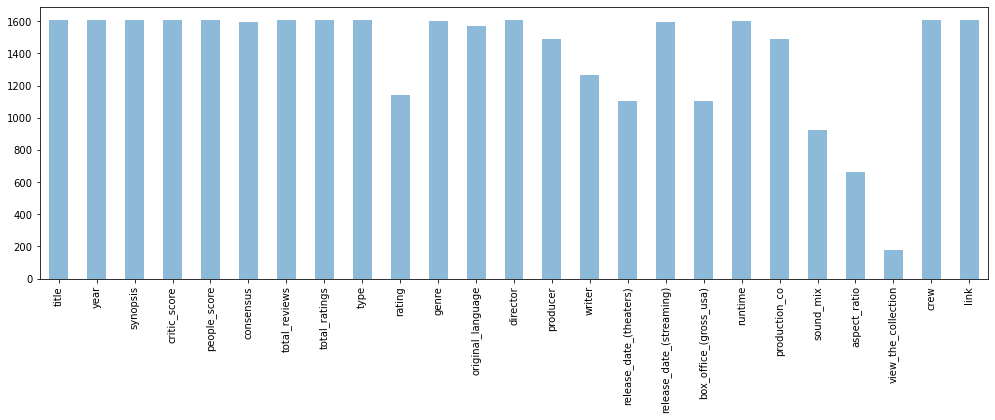

In [13]:
# Total de valores no nulos por columna
print(ds.count())

# Representación gráfica de los valores no nulos por columna
ds.count().plot(kind="bar",alpha=0.5,figsize=(17,5))
plt.show()

Por último, vamos a mostrar un ejemplo de las gráficas que se pueden generar para cononcer cómo se distribuyen los datos recogidos en el *dataset* que hemos generado.

El siguiente código genera estas cuatro gráficas:

1. Total de películas por categoría.
2. Total de películas por año de producción.
3. Suma de las puntuaciones obtenidas por categoría (películas de la última década).
4. Suma de las puntuaciones obtenidas por año (películas de la última década).

Para poder generar estas gráficas convertiremos en valores numéricos enteros el año y la puntuación de la crítica de cada película. Estas conversiones son parte de las operaciones de limpieza que se deberán llevar a cabo para poder utilizar este *dataset* en proyectos analíticos (otras serían, por ejemplo, eliminar las películas repetidas, convertir a valor numérico la recaudación total o la limpieza de los valores de las fechas de estreno en cines)

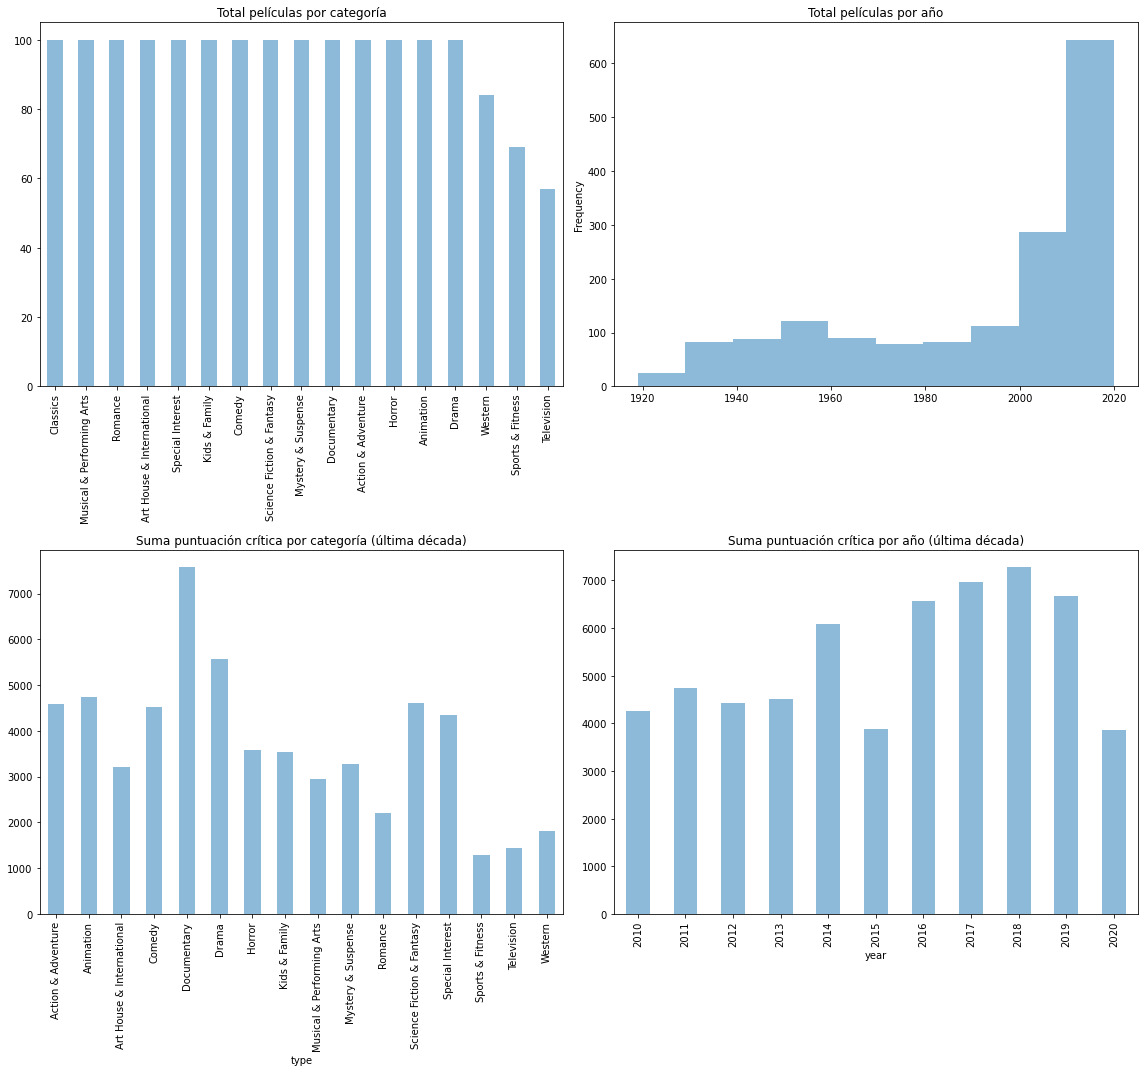

In [21]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

ds = pd.read_csv('top_movies_dataset.csv') 

# Cambiar el tipo de las columnas year y critic_score (por defecto son "object")
ds.astype({"year": "int32"}).dtypes
ds.astype({"critic_score": "int32"}).dtypes

#subplot(nrows, ncols, plot_number)

# Distribución de las películas por categoría
plt.subplot(2, 2, 1)
ds.type.value_counts().plot(kind="bar",alpha=0.5,figsize=(16,15))
plt.title("Total películas por categoría")

# Distribución de las películas por año
plt.subplot(2, 2, 2)
ds.year.plot.hist(alpha=0.5)
plt.title("Total películas por año")

# Puntuación total por categoría de las películas de la última década
plt.subplot(2, 2, 3)
ds[ds.year.astype(float) > 2009]["critic_score"].groupby(ds.type).sum().plot(kind="bar",alpha=0.5)
plt.title("Suma puntuación crítica por categoría (última década)")

# Puntuación total por año de las películas de la última década
plt.subplot(2, 2, 4)
ds[ds.year.astype(float) > 2009]["critic_score"].groupby(ds.year).sum().plot(kind="bar",alpha=0.5)
plt.title("Suma puntuación crítica por año (última década)")

plt.tight_layout()
plt.show()


Para finalizar, guardaremos el conjunto de datos como un fichero CSV:

In [22]:
# Guardamos el dataset como fichero de texto separado por comas
ds.to_csv("rotten_tomatoes_top_movies.csv") 
